<a href="https://colab.research.google.com/github/vsnupoudel/RandomAssignments/blob/main/LB_Clustering_Silhoeu_and_PCA_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install psycopg2
# !pip install yellowbrick

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import psycopg2

# Read pickle file
- Doing operations one after another for clarity, can be chained later

In [ ]:
!gdown --id '1QXmSdCPkJOJiX8FkzxV6qCI6ccl-U-76'

Downloading...
From: https://drive.google.com/uc?id=1QXmSdCPkJOJiX8FkzxV6qCI6ccl-U-76
To: /content/outputdf.zip
3.99MB [00:00, 125MB/s]


In [ ]:
!unzip -o 'outputdf.zip'

Archive:  outputdf.zip
  inflating: outputdf.pkl            


In [ ]:
opath = 'outputdf.pkl'
output = pd.read_pickle(opath)

In [ ]:
output.head(3)

login_hash  ... enable
0  58147CEE6BFB8404D6A78B1AF504DF3B  ...    1.0
1  58147CEE6BFB8404D6A78B1AF504DF3B  ...    1.0
2  58147CEE6BFB8404D6A78B1AF504DF3B  ...    1.0

[3 rows x 15 columns]

In [ ]:
output.isnull().sum()

login_hash          0
ticket_hash         0
server_hash         0
symbol              0
digits              0
cmd                 0
volume              0
open_time           0
open_price          0
close_time          0
contractsize        7
login_hash      91953
country_hash    91953
currency        91953
enable          91953
dtype: int64

**Users table is not very useful as the login_hash joined with only 8% of the trades.**

In [ ]:
output.dtypes

login_hash              object
ticket_hash             object
server_hash             object
symbol                  object
digits                   int64
cmd                      int64
volume                   int64
open_time       datetime64[ns]
open_price             float64
close_time      datetime64[ns]
contractsize           float64
login_hash              object
country_hash            object
currency                object
enable                 float64
dtype: object

- **Contract size is null for 7 instances. These rows will be deleted too, as imputing might not be a good idea in this case**

In [ ]:
output[ output.contractsize.isnull() ]

login_hash  ... enable
1983   D33487486545A737682F7D1E5ECEABD8  ...    NaN
21147  32DE9EECD10691C33D28F716CC255364  ...    NaN
71966  87664AA1F50A83BB2429989AA470A167  ...    NaN
92551  2BCA9F6675B4F907E51DE5570E443D2B  ...    NaN
92552  2BCA9F6675B4F907E51DE5570E443D2B  ...    NaN
92559  2BCA9F6675B4F907E51DE5570E443D2B  ...    NaN
92560  2BCA9F6675B4F907E51DE5570E443D2B  ...    NaN

[7 rows x 15 columns]

## Removing the users table joined as it is not useful

In [ ]:
output.drop(columns=['country_hash','currency','enable'], axis=1, inplace=True)

In [ ]:
df = output.iloc[:, :-1] #removing the duplicate column login_hash from users table part
# Do not run this twice, should be made reproducible

In [ ]:
df.head(2)

login_hash  ... contractsize
0  58147CEE6BFB8404D6A78B1AF504DF3B  ...     100000.0
1  58147CEE6BFB8404D6A78B1AF504DF3B  ...     100000.0

[2 rows x 11 columns]

In [ ]:
# output[ output.login_hash == '2BCA9F6675B4F907E51DE5570E443D2B']

## Observation
1. The user table does not have all the users data. About 8% of the login_hash IDs match. Not very useful, so won't bother clustering on country, currency etc. In fact the users table is not that useful at all.
2. Imputing Contractsize (using KNN imputer or others) might not be a good idea, as it is not dependant on any other variable. Will remove these rows entirely.

In [ ]:
df.shape

(100000, 11)

In [ ]:
df = df[~df.contractsize.isna()]

In [ ]:
df.shape

(99993, 11)

# Goal
You are also required to produce a simple K-Means clustering of the users. Assign each user to a single
cluster. Describe your choice for K and your logic for any pre-processing you have done. Please include
a performance evaluation. Present a frequency histogram for how many users are assigned to each cluster.
Please also provide a 3-D interactive graph using three principal components for the axis and the cluster
for the data point colour.


Your EDA should demonstrate your skill set, it should highlight novel findings about the data
and it will show your ability to analyse and tell stories with data. Please pay attention to
code quality and make sure you identify any issues with the data. 

## More EDA in pandas

In [ ]:
df.describe().transpose()

count          mean           std  ...      50%        75%       max
digits        99993.0      3.214335      1.463187  ...     2.00       5.00       5.0
cmd           99993.0      0.448161      0.497308  ...     0.00       1.00       1.0
volume        99993.0     17.980909    100.439958  ...     3.00      10.00   10000.0
open_price    99993.0   1262.624992   2585.183078  ...  1887.73    1967.16   28795.0
contractsize  99993.0  44856.840239  49669.111281  ...   100.00  100000.00  100000.0

[5 rows x 8 columns]

- **Seems Volume column has outliers. will look into that**

In [ ]:
df.describe(include= np.object).transpose()

count unique                               top   freq
login_hash   99993   5142  18D4C2E739573770F9DF198F0E51C1B9   1223
ticket_hash  99993  99993  EA5D2C4CE232F1C32FA1EA86E52F506C      1
server_hash  99993      3  2F1CA40D76D7E6165DBA3924CE0D3B5C  81059
symbol       99993     70                            XAUUSD  49165

## Reset the data type to save memory

In [ ]:
dtype_given = {'server_hash': 'category',
 'symbol': 'category',
 'contractsize':  'float64',
 'volume': 'float64',
  'cmd': 'bool',
'digits': 'float64'
              }
df = df.astype(dtype_given)

In [ ]:
import copy
df_copy = copy.deepcopy(df)

## K Means

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

- **Feature Engineering, take the log10 of 3 columns**

In [ ]:
df['interval_hour'] = (df.close_time - df.open_time).dt.seconds / 3600
df.loc[ df.volume <= 0. , 'volume'] = 0.001
df['volume'] = np.log10(df['volume'] )
df['open_price'] = np.log10(df['open_price'] )
df['contractsize'] = np.log10(df['contractsize'] )

In [ ]:
valid_columns = ['symbol','digits', 'cmd','volume', 'open_price','contractsize','interval_hour','server_hash']
categ_columns = ['symbol','server_hash']
df = df[valid_columns]

## ScatterPlot and Histograms

<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


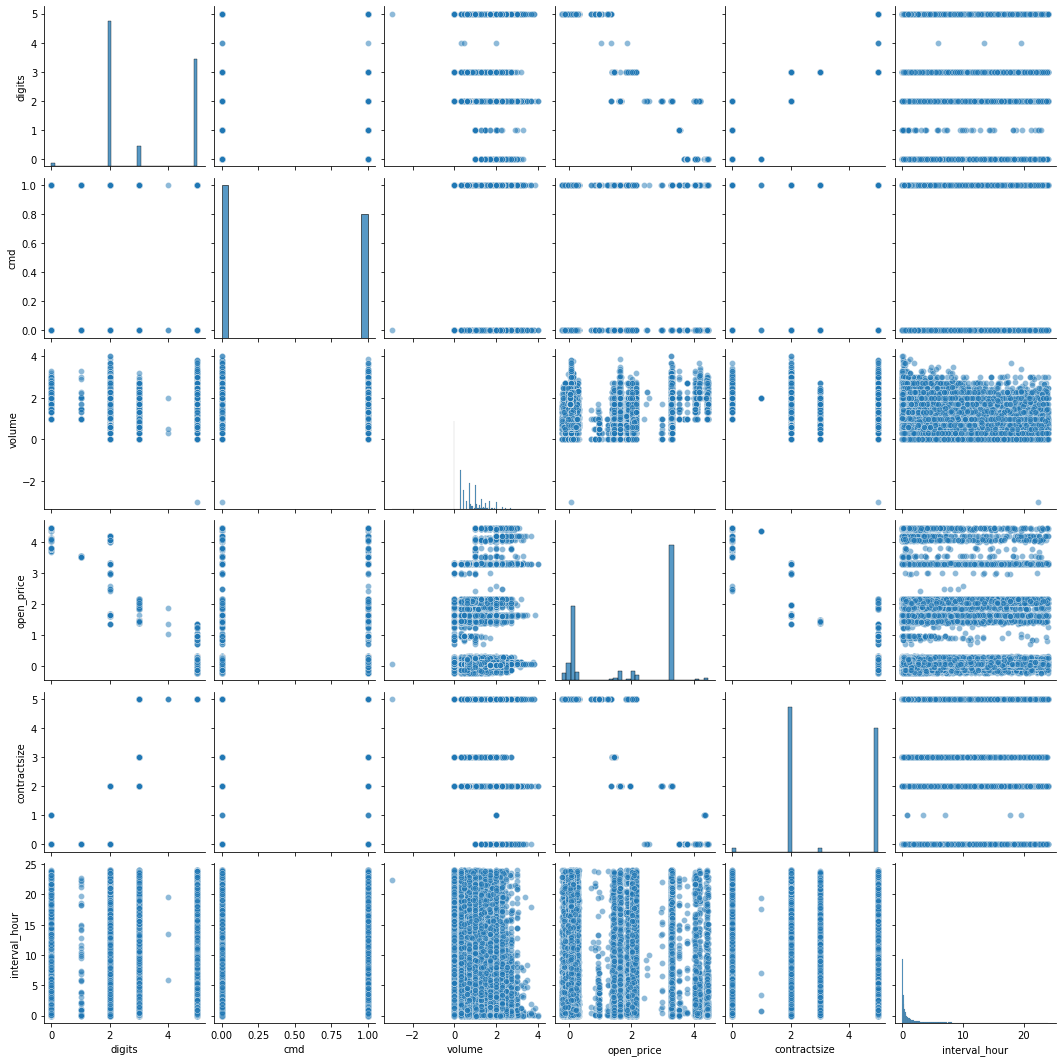

In [ ]:
import seaborn as sns
plt.figure(figsize=(8,8))
sns.pairplot(data=df, plot_kws=dict(alpha=0.5) )

## Observation:
- Features not highly correlated
- They  look independant also

In [ ]:

df_woh = copy.deepcopy(df)
df = pd.get_dummies(df, prefix='FromTo', prefix_sep='_', dummy_na=True, columns=categ_columns  )

## K means logic
- Will not use login_hash and ticket_hash as they are unique identifiers and won't help cluster similar points.
- Open time and close time are dates, which will not be very important as investment does not have a season generally.
- The interval between the open and close time will be considered ( in hours)
- Will run with value of k between 2 to 8, and then use silhouette method to choose K.

In [ ]:
pipeline = Pipeline([('scaler', StandardScaler()), ('svc', KMeans())]) # create a pipeline
scaled = StandardScaler().fit_transform(df)  # Get just the scaled version of variables

In [ ]:
kmfit = pipeline.fit_predict( df)  # fit the pipeline
np.unique(kmfit, return_counts=True) # count records in each cluster

(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int32),
 array([52841, 33384,   859,   717,  8788,  1044,  2352,     8]))

- **2 of the clusters are biggest than rest, by default gives 8 clusters**
**Fit works, so trying siloheutte method to find optimal K**
- Code taken from [Here](https://dzone.com/articles/kmeans-silhouette-score-explained-with-python-exam)

- **Will take upto an hour to produce plots**

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


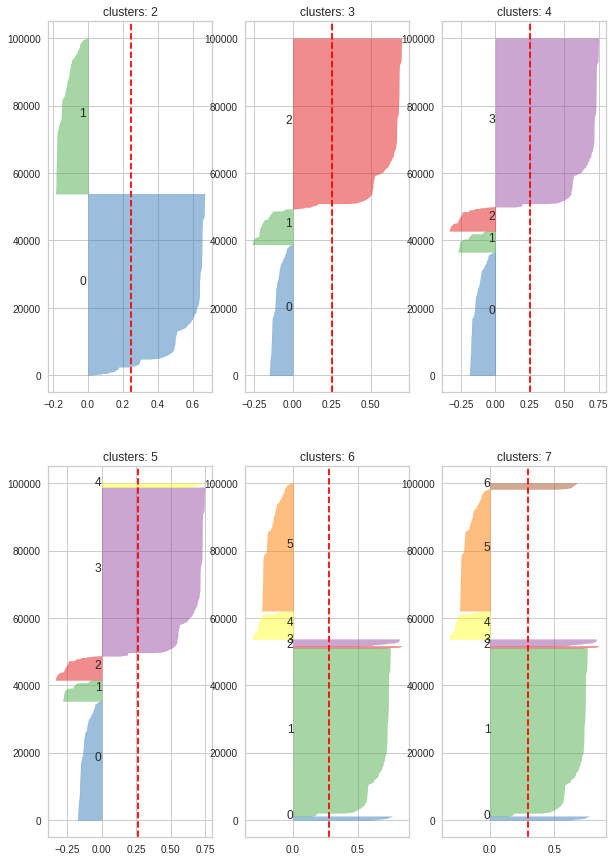

In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer
fig, ax = plt.subplots(2, 3, figsize=(10,15))

for i in range(2,8):
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=1)
    q, mod = divmod(i-2, 3)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q][mod])
    visualizer.fit(scaled)
    ax[q][mod].set_title('clusters: '+str(i) )

## Observation:
- Negative value in silhouette suggesting the clusters are not optimum.
- 6 clusters is where I get less records with negative silhouette score.
- Will use 6 clusters for the PCA plot

In [ ]:
pipeline = Pipeline([('scaler', StandardScaler()), ('kmeans', KMeans(n_clusters=6, random_state=1))])
segments_scaled = pipeline.fit_predict(scaled)

In [ ]:
from sklearn.metrics import silhouette_score
silhouette_score( scaled, pipeline['kmeans'].labels_)

0.27644535480704463

In [ ]:
print(scaled.shape)
print( segments_scaled.shape)

(99993, 81)
(99993,)


## Histogram part kind of covered by Silhouette figures also

In [ ]:
np.unique(segments_scaled, return_counts=True)

(array([0, 1, 2, 3, 4, 5], dtype=int32),
 array([ 1100, 50009,   567,  1989,  8409, 37919]))

(array([ 1100., 50009.,   567.,  1989.,  8409., 37919.]),
 array([0.        , 0.83333333, 1.66666667, 2.5       , 3.33333333,
        4.16666667, 5.        ]),
 <a list of 6 Patch objects>)

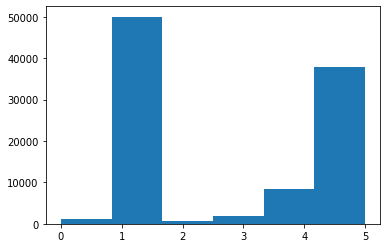

In [ ]:
plt.hist(segments_scaled, range=(0,5), bins=6)

## PCA

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=20)
pca_fit = pca.fit(scaled)

In [ ]:
pca_fit.explained_variance_ratio_

array([0.05613726, 0.02523894, 0.01660789, 0.01529359, 0.01433514,
       0.01336571, 0.01328965, 0.01299963, 0.01288332, 0.01278677,
       0.01277386, 0.01273533, 0.01273081, 0.0127139 , 0.0127076 ,
       0.01270163, 0.01269791, 0.0126925 , 0.01268507, 0.01268269])

- **PCA is unable to find a good percent of explained variance using a few components. ( The first 3 add up to less than 10%)**

In [ ]:
pca_3 = pca_fit.transform(scaled)[: , :3]


## Plotly seems to have a nicer 3d rotating plot.
- The response in the dynamic buttons not so good here in colab.


In [ ]:
import plotly.express as px
fig = px.scatter_3d(x= pca_3[: , 0], y=pca_3[: , 1], z=pca_3[: , 2],
              color=segments_scaled , opacity=.5, width=1000, height=400)
fig.update_traces(marker=dict(size=2))
fig.show()

## Conclusions
- Unable to get good segments. No distinct segments found.
- PCA was not able to explain variance. 

## Next steps- (but the assignment says K means and PCA only)
- Hierarchical and DBSCAN clustering in scikit learn

In [1]:
from sklearn.cluster import DBSCAN